# `PyTorch` for Deep Learning

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/notebooks/Lab-11.Pytorch_NN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE**: This notebook is the same as the *non-solved* version.


In the following Lab, we will learn how to define, train and evaluate a *Neural Network* model in PyTorch. We will use a simple *Convolutional Neural Network* as an example, and we will train it on the *MNIST* dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

## Intro to PyTorch

`PyTorch` is a Python/C++-based *Deep Learning* and *scientific computing* package that mainly provides two high-level features:  
* **Tensor computation** (like `NumPy`) with strong GPU acceleration 
* **Deep neural networks** built on an **autograd** system ([more info](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html))

The flexibility of `PyTorch` and its *Pythonic* interfaces make it the most widely adopted framework for research and development, both in academia and industry.

For more info, you can have a look at the [official documentation](https://pytorch.org/docs/stable/index.html) or refer to [this book](https://isip.piconepress.com/courses/temple/ece_4822/resources/books/Deep-Learning-with-PyTorch.pdf).

Fun fact: *PyTorch was first created by Meta AI in 2016, and is now the base for Tesla's autopilot!* 

Like NumPy, PyTorch provides its own multidimensional array class, called `Tensor`. `Tensor`s are essentially the equivalent of NumPy `ndarray`s.
* `Tensor` draws a lot of methods from NumPy
* `Tensor` has CUDA support (faster!)

In [2]:
# create custom Tensor and ndarray
x = torch.Tensor([[1,5,4],[3,2,1]])
y = np.array([[1,5,4],[3,2,1]])

def pretty_print(obj, title=None):
    if title is not None:
        print(title)
    print(obj)
    print("\n")

pretty_print(x, "x")
pretty_print(y, "y")

x
tensor([[1., 5., 4.],
        [3., 2., 1.]])


y
[[1 5 4]
 [3 2 1]]




What are these types of objects?

In [3]:
print(x.dtype)
print(y.dtype)

torch.float32
int64


`torch` already thinks with Machine Learning in mind as the `Tensor` is implicitly converted to `dtype float32`, while NumPy makes no such assumption.

For more info on `Tensor` data types, check the beginning of [this page](https://pytorch.org/docs/stable/tensors.html).

As in NumPy, we can call the `.shape` attribute to get the shape of the structures. Moreover, `Tensor`s have also the `.size()` method which is analogous to `.shape`.

In [4]:
print(x.shape)
print(y.shape)
print(x.size())

torch.Size([2, 3])
(2, 3)
torch.Size([2, 3])


Notice how a `Tensor` shape is **not** a tuple.

We can also create a random `Tensor` analogously to NumPy.

A `2 × 3 × 3` `Tensor` is the same as saying "2 3 × 3 matrices", or a "cubic matrix"

In [5]:
x = torch.rand([2, 3, 3])
x

tensor([[[0.4621, 0.3844, 0.1777],
         [0.8900, 0.4758, 0.8073],
         [0.2538, 0.8338, 0.9360]],

        [[0.4021, 0.6811, 0.8854],
         [0.9554, 0.5059, 0.1259],
         [0.9241, 0.0194, 0.7319]]])

## Training a simple *Convolutional Neural Network* on the *MNIST* dataset


In [6]:
# A good idea is to start with ~32 (Masters and Luschi, 2018 | https://arxiv.org/abs/1804.07612)
BATCH_SIZE = 32

### Getting and loading the data
There are potentially other -- more *handcrafted* -- ways to load the data. However, it is always a good practice to rely on `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes, as they provide many useful functionalities, such as automated *batching*, *shuffling*, loading *parallelization* and *data augmentation* (`transforms`).

In [7]:
# Convert data to PyTorch tensor form 
data_transforms = transforms.ToTensor()

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualising the data
Let's have a look at some of the images in the data set.

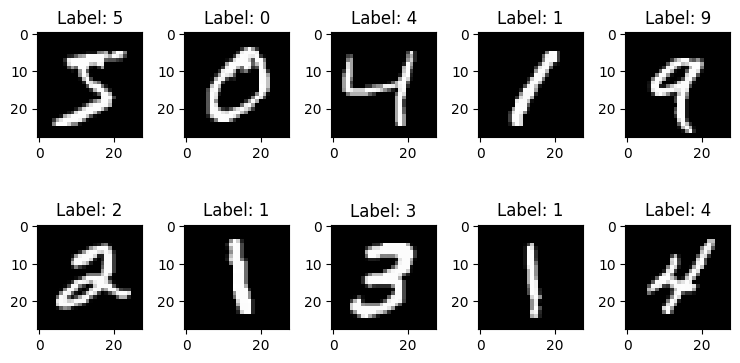

In [8]:
num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

In [9]:
# printing data shapes 
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


### Defining the model

In `PyTorch`, we define a model by subclassing the `nn.Module` class and defining the `forward` method. The `forward` method is where we define the *computation* that happens at every *forward pass* of the model.

Except for extreme corner-cases, the backward pass is automatically defined by `PyTorch` *autograd* system and gradients are obtained efficiently whenever needed.

`PyTorch` modules are *transparent* with respect to batch sizes, i.e. we can use the same model to process a single sample or a batch of samples, without worrying about the exact batch size.

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.l1 = nn.Linear(32 * 26 * 26, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = x.flatten(start_dim = 1)

        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        x = F.relu(x)

        # BSx128 => BSx10
        logits = self.l2(x)

        # Softmax computation
        out = F.softmax(logits, dim=1)
        
        return out

### Model instantiation and test with a single batch
We haven't trained the model yet, so it's not going to give us good results. However, we can still test it on a single batch of data to see if it works from the implementation viewpoint.

In [11]:
model = MyModel()
out = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([32, 10])  i.e.: batch_size x num_classes


In [12]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

print(f"Accuracy on the single batch just used: {get_batch_accuracy(out, labels)}%")

Accuracy on the single batch just used: 6.25%


In [13]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Re-instantiate the model to reset the weights/gradients. 
# Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = MyModel()  
model = model.to(device)  # Move the model to the selected device

print(f"Using device: {device}")

Using device: cpu


In [14]:
# Number of times the whole (training) dataset is used for training
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training loop

Using `CPU`, this training loop is very slow. We can run it on [GPU](https://cloud.google.com/gpu) and make it very quick even on Colab by going to `Runtime` > `Change runtime type` and selecting `GPU` from the `Hardware accelerator` drop-down.

In [15]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    # Set the model to training mode: relevant for dropout, batchnorm, etc.
    model = model.train()
    start = time()
    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)

        # Reset the gradients to zero: otherwise they accumulate!
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.item()
        train_acc += get_batch_accuracy(logits, labels)
    
    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")        

Epoch: 1 | Loss: 1.6447 | Train Accuracy: 82.0037 | Time: 162.61
Epoch: 2 | Loss: 1.4935 | Train Accuracy: 97.0651 | Time: 167.88
Epoch: 3 | Loss: 1.4839 | Train Accuracy: 97.9672 | Time: 178.60
Epoch: 4 | Loss: 1.4788 | Train Accuracy: 98.4492 | Time: 175.34
Epoch: 5 | Loss: 1.4765 | Train Accuracy: 98.6526 | Time: 173.41


Without GPU: ~160s/epoch   
With GPU: ~13s/epoch   


### Test loop

In [16]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)
        
print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 98.1370
